In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
import matplotlib.pyplot as plt

In [5]:
drive.mount('/content/drive')
FEDFUNDS = pd.read_csv('/content/drive/My Drive/monetary-policy-consumer-credit/FEDFUNDS.csv')
REVOLSL= pd.read_csv('/content/drive/My Drive/monetary-policy-consumer-credit/REVOLSL.csv')
UNRATE = pd.read_csv('/content/drive/My Drive/monetary-policy-consumer-credit/UNRATE.csv')
CPIAUCSL = pd.read_csv('/content/drive/My Drive/monetary-policy-consumer-credit/CPIAUCSL.csv')
A229RX0 = pd.read_csv('/content/drive/My Drive/monetary-policy-consumer-credit/A229RX0.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.DataFrame()
df['observation_date'] = REVOLSL['observation_date']
df['logREV'] = np.log(REVOLSL['REVOLSL'])
df['FEDFUNDS'] = FEDFUNDS['FEDFUNDS']
df['UNRATE'] = UNRATE['UNRATE']
df['CPI'] = CPIAUCSL['CPIAUCSL']
df['RDPI'] = A229RX0['A229RX0']
df = df.dropna()
print(df.head())

  observation_date     logREV  FEDFUNDS  UNRATE    CPI   RDPI
0       1994-01-01  12.652429      3.05     6.6  146.3  29694
1       1994-02-01  12.661640      3.25     6.6  146.7  29725
2       1994-03-01  12.675380      3.34     6.5  147.1  29793
3       1994-04-01  12.691629      3.56     6.4  147.2  29763
4       1994-05-01  12.704110      4.01     6.1  147.5  30077


In [8]:
REVOLSL_GFC = REVOLSL[(REVOLSL['observation_date'] >= '2007-03-01') & (REVOLSL['observation_date'] <= '2009-03-01')]
FEDFUNDS_GFC = FEDFUNDS[(FEDFUNDS['observation_date'] >= '2007-03-01') & (FEDFUNDS['observation_date'] <= '2009-03-01')]
UNRATE_GFC = UNRATE[(UNRATE['observation_date'] >= '2007-03-01') & (UNRATE['observation_date'] <= '2009-03-01')]
CPIAUCSL_GFC = CPIAUCSL[(CPIAUCSL['observation_date'] >= '2007-03-01') & (CPIAUCSL['observation_date'] <= '2009-03-01')]
A229RX0_GFC = A229RX0[(A229RX0['observation_date'] >= '2007-03-01') & (A229RX0['observation_date'] <= '2009-03-01')]

df_GFC = pd.DataFrame()
df_GFC['observation_date'] = REVOLSL.loc[(REVOLSL['observation_date'] >= '2007-03-01') & (REVOLSL['observation_date'] <= '2009-03-01'), 'observation_date']

df_GFC['logREV'] = np.log(REVOLSL_GFC['REVOLSL'])
df_GFC['FEDFUNDS'] = FEDFUNDS_GFC['FEDFUNDS']
df_GFC['UNRATE'] = UNRATE_GFC['UNRATE']
df_GFC['CPI'] = CPIAUCSL_GFC['CPIAUCSL']
df_GFC['RDPI'] = A229RX0_GFC['A229RX0']
df_GFC = df_GFC.dropna()

The dataset was extracted for two years period: March 2007 to March 2009, the time when Global Financial Crisis(GFC) took place.

In [10]:
REVOLSL_COVID = REVOLSL[(REVOLSL['observation_date'] >= '2020-03-01') & (REVOLSL['observation_date'] <= '2023-05-01')]
FEDFUNDS_COVID = FEDFUNDS[(FEDFUNDS['observation_date'] >= '2020-03-01') & (FEDFUNDS['observation_date'] <= '2023-05-01')]
UNRATE_COVID = UNRATE[(UNRATE['observation_date'] >= '2020-03-01') & (UNRATE['observation_date'] <= '2023-05-01')]
CPIAUCSL_COVID = CPIAUCSL[(CPIAUCSL['observation_date'] >= '2020-03-01') & (CPIAUCSL['observation_date'] <= '2023-05-01')]
A229RX0_COVID = A229RX0[(A229RX0['observation_date'] >= '2020-03-01') & (A229RX0['observation_date'] <= '2023-05-01')]

df_COVID = pd.DataFrame()
df_COVID['observation_date'] = REVOLSL.loc[(REVOLSL['observation_date'] >= '2020-03-01') & (REVOLSL['observation_date'] <= '2023-05-01'), 'observation_date']

df_COVID['logREV'] = np.log(REVOLSL_COVID['REVOLSL'])
df_COVID['FEDFUNDS'] = FEDFUNDS_COVID['FEDFUNDS']
df_COVID['UNRATE'] = UNRATE_COVID['UNRATE']
df_COVID['CPI'] = CPIAUCSL_COVID['CPIAUCSL']
df_COVID['RDPI'] = A229RX0_COVID['A229RX0']
df_COVID = df_COVID.dropna()

The dataset was extracted for 38 months period.
In March 2020, WHO declared outbreak of COVID 19 and they announced the end of pandemic in May 2023.

In [11]:
def local_projection(df, h = 1, p = 12, target = 'FEDFUNDS_diff_1'):
  df = df.copy()
  # Dependent variable, h-step ahead log change
  df['y_lead'] = df['logREV'].shift(-h) - df['logREV']

  #Indepdent variable
  df['FEDFUNDS_diff_1'] = df['FEDFUNDS'].diff(1)

  # Control variabels, CPI and RDPI growth rates
  # UNRATE does not use growth rates
  df['dCPI'] = np.log(df['CPI']) - np.log(df['CPI'].shift(1))
  df['dRDPI'] = np.log(df['RDPI']) - np.log(df['RDPI'].shift(1))

  # Lag controls to t-1
  df['dCPI_lag1'] = df['dCPI'].shift(1)
  df['dRDPI_lag1'] = df['dRDPI'].shift(1)
  df['UNRATE_lag1'] = df['UNRATE'].shift(1)

  # Lags of logREV
  for j in range(1,p+1):
    df[f'logREV_lag{j}'] = df['logREV'].shift(j)

  # Choose columns for regression
  cols_X = [target, 'UNRATE_lag1', 'dCPI_lag1', 'dRDPI_lag1'] + [f'logREV_lag{j}' for j in range(1,p+1)]
  model_df = df[['y_lead'] + cols_X].dropna()

  # Build design matrix
  y = model_df['y_lead']
  X = sm.add_constant(model_df[cols_X])

  model = sm.OLS(y, X).fit()

  # HAC/Newey-West SE for lag h
  cov = cov_hac(model, nlags = h)
  se = np.sqrt(np.diag(cov))

  # Extract coefficient and SE for target
  idx = list(X.columns).index(target)
  coef = model.params[target]
  tstat = coef/se[idx]

  return {
      "horizon": h,
      "coefficients": coef,
      "standard_errors": se[idx],
      "tstat": tstat,
      "observations_used": len(model_df),
      "model": model
  }


In [12]:
# Result, from Jan 1994 to Dec 1994, p = 12
horizons = [1,3,6,12]
results = []

for h in horizons:
  res = local_projection(df, h = h, p = 12)
  results.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_df = pd.DataFrame(results)
results_df["CI_lower"] = results_df["coefficients"] - 1.96 * results_df["standard_errors"]
results_df["CI_upper"] = results_df["coefficients"] + 1.96 * results_df["standard_errors"]
print(results_df)

    h  coefficients  standard_errors     tstat  CI_lower  CI_upper
0   1      0.010979         0.004934  2.225206  0.001308  0.020649
1   3      0.024075         0.008056  2.988353  0.008285  0.039865
2   6      0.051841         0.011429  4.535765  0.029440  0.074243
3  12      0.102590         0.018541  5.533122  0.066249  0.138930


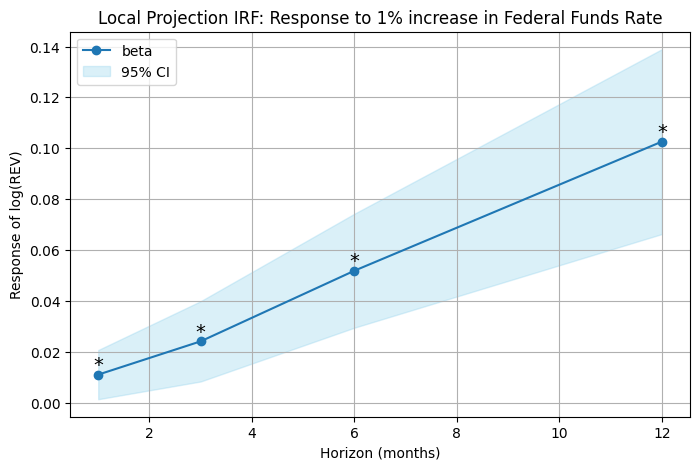

In [13]:
# Visualization of Beta_h with 95% Confidence Interval
plt.figure(figsize = (8,5))

plt.plot(results_df["h"], results_df["coefficients"], marker = "o", label = "beta")

plt.fill_between(
    results_df["h"],
    results_df["CI_lower"],
    results_df["CI_upper"],
    color = "skyblue",
    alpha = 0.3,
    label = "95% CI"
)

for i, row in results_df.iterrows():
  if abs(row["tstat"]) > 1.96:
    plt.text(row["h"], row["coefficients"], "*", fontsize = 14, ha = "center", va = "bottom")

plt.xlabel("Horizon (months)")
plt.ylabel("Response of log(REV)")
plt.title("Local Projection IRF: Response to 1% increase in Federal Funds Rate")
plt.legend()
plt.grid(True)
plt.savefig("localprojection.png")

In [14]:
# Results(GFC), p = 3 since extracted time interval is quite short
horizons = [1,3,6,12]
results_GFC = []

for h in horizons:
  res = local_projection(df_GFC, h = h, p = 3)
  results_GFC.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_GFC_df = pd.DataFrame(results_GFC)
results_GFC_df["CI_lower"] = results_GFC_df["coefficients"] - 1.96 * results_GFC_df["standard_errors"]
results_GFC_df["CI_upper"] = results_GFC_df["coefficients"] + 1.96 * results_GFC_df["standard_errors"]
print(results_GFC_df)

    h  coefficients  standard_errors      tstat  CI_lower  CI_upper
0   1      0.003702         0.001059   3.496231  0.001627  0.005778
1   3     -0.001148         0.002124  -0.540631 -0.005312  0.003015
2   6     -0.000164         0.001771  -0.092477 -0.003634  0.003307
3  12     -0.007924         0.000786 -10.077883 -0.009465 -0.006383


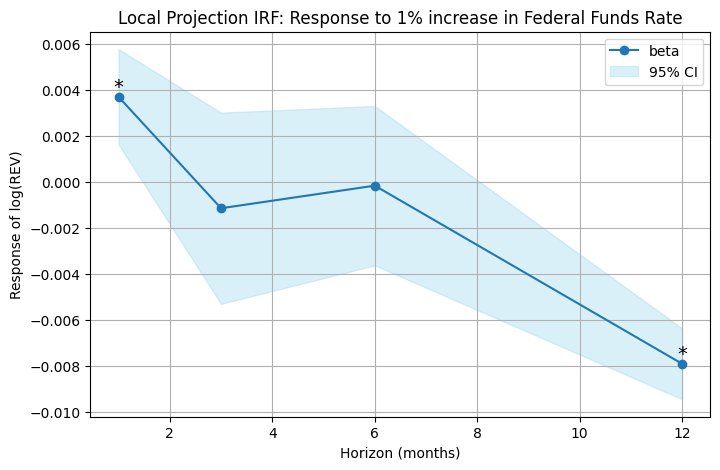

In [15]:
# Visualization of Beta_h with 95% Confidence Interval
plt.figure(figsize = (8,5))

plt.plot(results_GFC_df["h"], results_GFC_df["coefficients"], marker = "o", label = "beta")

plt.fill_between(
    results_GFC_df["h"],
    results_GFC_df["CI_lower"],
    results_GFC_df["CI_upper"],
    color = "skyblue",
    alpha = 0.3,
    label = "95% CI"
)

for i, row in results_GFC_df.iterrows():
  if abs(row["tstat"]) > 1.96:
    plt.text(row["h"], row["coefficients"], "*", fontsize = 14, ha = "center", va = "bottom")

plt.xlabel("Horizon (months)")
plt.ylabel("Response of log(REV)")
plt.title("Local Projection IRF: Response to 1% increase in Federal Funds Rate")
plt.legend()
plt.grid(True)
plt.savefig("localprojection_GFC.png")

In [16]:
# Results(COVID-19 Pandemic), p = 3 since extracted time interval is short
horizons = [1,3,6,12]
results_COVID = []

for h in horizons:
  res = local_projection(df_COVID, h = h, p = 3)
  results_COVID.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_COVID_df = pd.DataFrame(results_COVID)
results_COVID_df["CI_lower"] = results_COVID_df["coefficients"] - 1.96 * results_COVID_df["standard_errors"]
results_COVID_df["CI_upper"] = results_COVID_df["coefficients"] + 1.96 * results_COVID_df["standard_errors"]
print(results_COVID_df)

    h  coefficients  standard_errors     tstat  CI_lower  CI_upper
0   1     -0.000480         0.003987 -0.120280 -0.008294  0.007335
1   3     -0.016058         0.010518 -1.526707 -0.036674  0.004557
2   6     -0.041063         0.018502 -2.219444 -0.077326 -0.004800
3  12     -0.031279         0.035044 -0.892547 -0.099966  0.037408


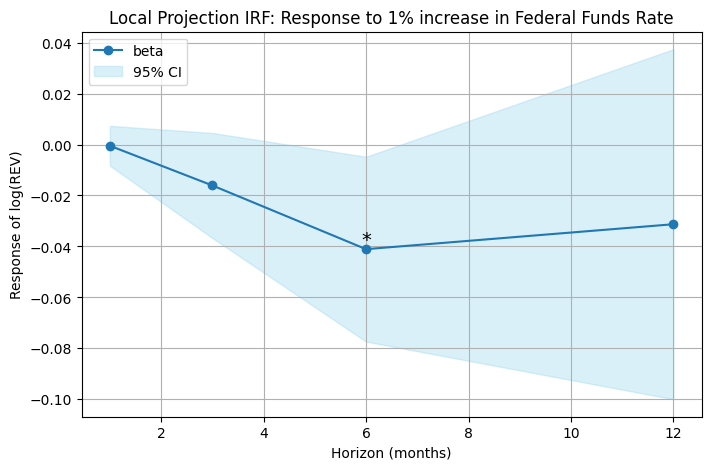

In [17]:
# Visualization of Beta_h with 95% confidence interval
plt.figure(figsize = (8,5))

plt.plot(results_COVID_df["h"], results_COVID_df["coefficients"], marker = "o", label = "beta")

plt.fill_between(
    results_COVID_df["h"],
    results_COVID_df["CI_lower"],
    results_COVID_df["CI_upper"],
    color = "skyblue",
    alpha = 0.3,
    label = "95% CI"
)
for i, row in results_COVID_df.iterrows():
  if abs(row["tstat"]) > 1.96:
    plt.text(row["h"], row["coefficients"], "*", fontsize = 14, ha = "center", va = "bottom")

plt.xlabel("Horizon (months)")
plt.ylabel("Response of log(REV)")
plt.title("Local Projection IRF: Response to 1% increase in Federal Funds Rate")
plt.legend()
plt.grid(True)
plt.savefig("localprojection_COVID.png")

In [18]:
# Comparison (Full vs. GFC vs. COVID-19 Pandemic)
horizons = [1,3,6,12]
results = []

for h in horizons:
  res = local_projection(df, h = h, p = 3)
  results.append({
      "h": h,
      "coefficients": res["coefficients"],
      "standard_errors": res["standard_errors"],
      "tstat": res["tstat"],
  })

results_df = pd.DataFrame(results)
results_df["CI_lower"] = results_df["coefficients"] - 1.96 * results_df["standard_errors"]
results_df["CI_upper"] = results_df["coefficients"] + 1.96 * results_df["standard_errors"]
print(results_df)

    h  coefficients  standard_errors     tstat  CI_lower  CI_upper
0   1      0.010278         0.004560  2.253662  0.001339  0.019216
1   3      0.024848         0.007597  3.270672  0.009957  0.039738
2   6      0.053642         0.010320  5.197925  0.033415  0.073870
3  12      0.106745         0.015505  6.884624  0.076355  0.137134


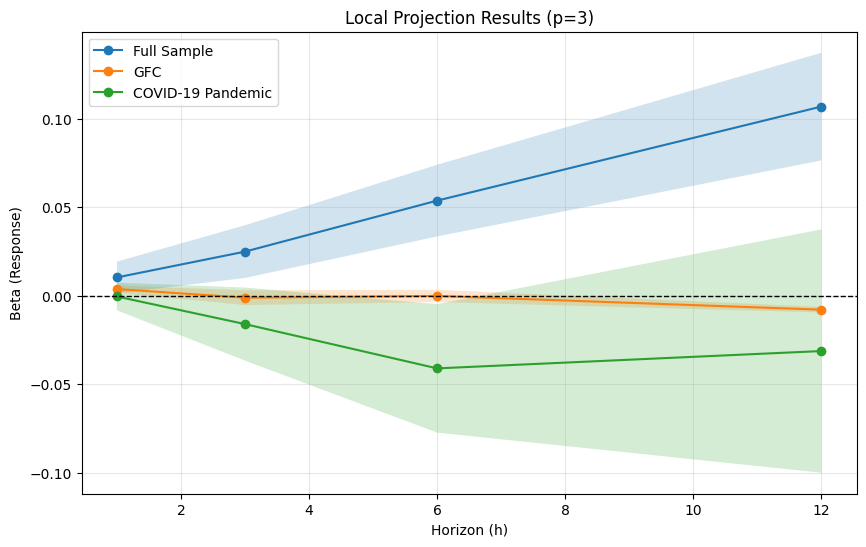

In [19]:
results = {
    "Full Sample": results_df,
    "GFC": results_GFC_df,
    "COVID-19 Pandemic": results_COVID_df
}

plt.figure(figsize = (10,6))

for label, data in results.items():
  beta = data["coefficients"]
  se = data["standard_errors"]
  ci_lower = data["CI_lower"]
  ci_upper = data["CI_upper"]
  plt.plot(data["h"], beta, marker = "o", label = f'{label}')
  plt.fill_between(horizons, ci_lower, ci_upper, alpha = 0.2)

plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel("Horizon (h)")
plt.ylabel("Beta (Response)")
plt.title("Local Projection Results (p=3)")
plt.legend()
plt.grid(alpha = 0.3)
plt.savefig("localprojection_comparison.png")